# Training

In [ ]:
# install libraries
!pip install torchmetrics --quiet
!pip install pytorch_lightning --quiet
!pip install tqdm --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.3/761.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 725.0/725.0 kB 3.2 MB/s eta 0:00:00


In [ ]:
import torch # model creation
import torchvision # data loaders
from torchvision import transforms # data augmentation and normalization
import torchmetrics # easy metric computation
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint # frequently store weights
from pytorch_lightning.loggers import TensorBoardLogger # logging in TensorBoard
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# load files from drive
#https://drive.google.com/file/d/10P45MR63Uy7poTTd5p4OLKMMbcrACeqd/view?usp=sharing
#https://drive.google.com/drive/folders/1PQpoJL2cxM6j2-DAiMjsWlC68Tjleqn6?usp=sharing
#https://drive.google.com/file/d/1-7gNNuOe5XWsTJB5G519Ah_ZE31QuX61/view?usp=sharing
import gdown

url = 'https://drive.google.com/uc?id=1-7gNNuOe5XWsTJB5G519Ah_ZE31QuX61'
output = './'

gdown.download(url, output)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1-7gNNuOe5XWsTJB5G519Ah_ZE31QuX61
From (redirected): https://drive.google.com/uc?id=1-7gNNuOe5XWsTJB5G519Ah_ZE31QuX61&confirm=t&uuid=e6ecf60d-f8f5-4cf1-b280-1591a0055b2f
To: /kaggle/working/Processed2.zip
100%|██████████| 1.91G/1.91G [01:54<00:00, 16.7MB/s]


'./Processed2.zip'

In [ ]:
!unzip -q /kaggle/working/Processed2.zip

In [ ]:
!cp -r /kaggle/working/content/drive/Shareddrives/Gdrive/Dataset/Pneumonia_Detection/Processed ./

In [ ]:
!rm -r content

In [ ]:
!rm /kaggle/working/Processed2.zip

## Create train and validation dataset

In [ ]:
def load_file(path):
    # Load the file as a numpy array
    # Convert the data to float32 type
    return np.load(path).astype(np.float32)

In [ ]:
# train_transforms is a set of transformations to be applied to the training data
# transforms.ToTensor() converts the image to a tensor
# transforms.normalize(0.49, 0.248) normalizes the tensor by subtracting the mean of 0.49 and dividing by the standard deviation of 0.248
# transforms.RandomAffine(degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)) applies a random affine transformation to the image
#rotating it by a random angle between -5 to 5 degrees, translating it randomly by up to 5% in both the x and y directions, and scaling it randomly between 0.9 to 1.1 times
# transforms.RandomResizedCrop((224, 224), scale=(0.35, 1)) applies a random resized crop to the image, cropping it to a size of 224x224 with a random scale between 0.35 to 1

# val_transforms is a set of transformations to be applied to the validation data
# It has the same transformations as train_transforms, except without the random affine and random resized crop transformations

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.248),
    transforms.RandomAffine(degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop((224, 224), scale=(0.35, 1))
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.49, 0.248)
])

In [ ]:
train_dataset = torchvision.datasets.DatasetFolder('/content/drive/Shareddrives/Gdrive/Dataset/Pneumonia_Detection/Processed/train/',
                                                   loader = load_file, extensions='npy', transform=train_transforms)

val_dataset = torchvision.datasets.DatasetFolder('/content/drive/Shareddrives/Gdrive/Dataset/Pneumonia_Detection/Processed/val/',
                                                   loader = load_file, extensions='npy', transform=val_transforms)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


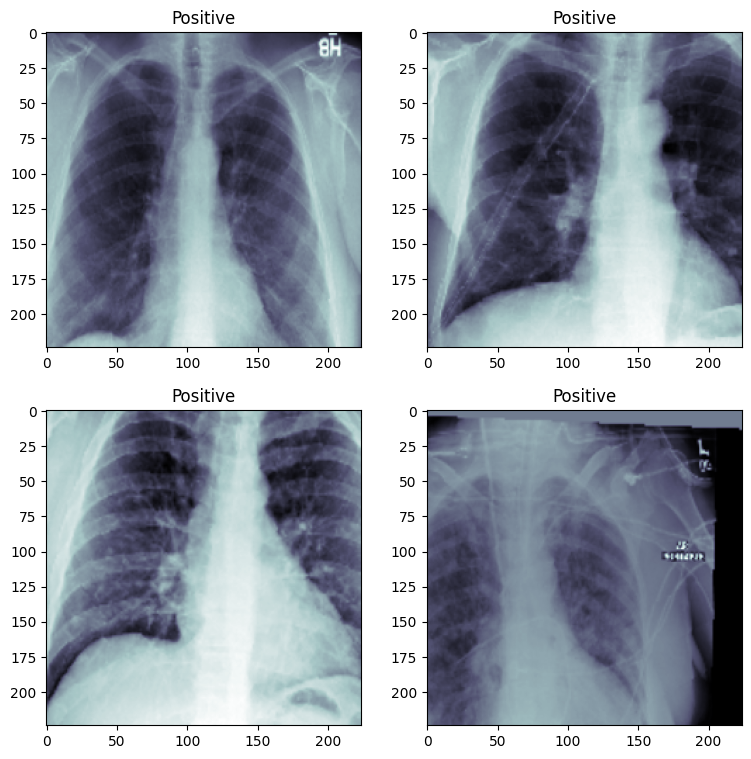

In [ ]:
# visualize some samples to see the effect of augmentation
fig, axis = plt.subplots(2, 2, figsize=(9,9))

for i in range(2):
    for j in range(2):

        random_idx = np.random.randint(0, 24000)

        x_ray, label = train_dataset[random_idx]

        axis[i][j].imshow(x_ray[0], cmap='bone')
        label_str = 'Positive' if label == 0 else 'Negative'
        axis[i][j].set_title(label_str)

In [ ]:
# set hyper parameters
batch_size = 512
num_workers = 2

In [ ]:
# create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size, num_workers=num_workers, shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [ ]:
# check the distribution of data
np.unique(train_dataset.targets, return_counts=True)

(array([0, 1]), array([18593,  5407]))

# Model Creation

## printing ResNet18

In [ ]:
torchvision.models.resnet18()
# name of the first convolution layer is "conv1"
# name of the last FC layer is "fc"

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
class PneumoniaModel(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18()

        # adapt the predefined model to out problem
        # in this case I needed to change the input channels from 3 to 1
        # this problem is a binary classification so we need one out_feature
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)

        # create the optimizer
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)

        # loss function
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight= torch.tensor([3]))

        # create the metric
        self.train_acc = torchmetrics.Accuracy(task='binary')
        self.val_acc = torchmetrics.Accuracy(task='binary')

    def forward(self, data):
        '''This function is responsible for computing the forward pass'''
        pred = self.model(data)
        return pred

    def training_step(self, batch, batch_idx):

        x_ray, label = batch
        label = label.float()

        pred = self(x_ray)[:, 0]

        loss = self.loss_fn(pred, label)

        self.log('Train Loss', loss)
        self.log('Step Train Acc', self.train_acc(torch.sigmoid(pred), label.int()))

        return loss

    def on_train_epoch_end(self, outs):
        self.log('Train ACC', self.train_acc.compute())

    def validation_step(self, batch, batch_idx):

        x_ray, label = batch
        label = label.float()

        pred = self(x_ray)[:, 0]

        loss = self.loss_fn(pred, label)

        self.log('Val Loss', loss)
        self.log('Step Val Acc', self.val_acc(torch.sigmoid(pred), label.int()))

    def on_validation_epoch_end(self):
        self.log('Val ACC', self.val_acc.compute())

    def configure_optimizers(self):
        return [self.optimizer]

In [ ]:
# create model
model = PneumoniaModel()

In [ ]:
# create Checkpoint callbacks
checkpoint_callback = ModelCheckpoint(
    monitor= 'Val ACC',
    save_top_k= 10,
    mode = 'max'
)

In [ ]:
# create the trainer

trainer = pl.Trainer(accelerator="auto", logger=TensorBoardLogger(
    save_dir='/content/drive/Shareddrives/Gdrive/Dataset/Pneumonia_Detection/logs'),
    log_every_n_steps= 1, callbacks= checkpoint_callback, max_epochs=35)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_loader, val_loader)

In [ ]:
trainer.save_checkpoint('Pneumonia_Detetion_Resnet18_Epoch35.ckpt')